# Homework 3 - Bacteria Classification

## If you are on Google Colab

1. For better performance: select 'GPU' as a hardware accelerator in your Notebook settings
2. Navigate to the folder you want to clone our [github repository](https://github.com/MockaWolke/iannwtf1) (you can do this by running `%cd <FILEPATH>`)
3. Execute the cell below
4. After running this notebook you can delete the repository from your disk by navigating to your prior specified filepath `%cd /<FILEPATH>` and run `%rm -rf iannwtf1`

In [1]:
!git clone https://github.com/MockaWolke/iannwtf1.git
%cd iannwtf1/HW3_bacteria

Cloning into 'iannwtf1'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 177 (delta 76), reused 104 (delta 35), pack-reused 0
Receiving objects: 100% (177/177), 220.98 KiB | 5.97 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/iannwtf1/HW3_bacteria


## Now you are set up

In [2]:
# import python scrips
from layer import Dense_Layer
from model import MyModel
from preprocessing import onehotify, prep_data
# import libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
# function for model training
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [4]:
# function for model testing
def test(model, test_data, loss_function):

    test_accuracy_aggregator = np.empty(0) # we use numpy arrays to speed things up
    test_loss_aggregator = np.empty(0)

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator = np.append(test_loss_aggregator, sample_test_loss.numpy())
        test_accuracy_aggregator = np.append(test_accuracy_aggregator, np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [5]:
tf.keras.backend.clear_session()

# load dataset
# we only load from the training set to avoid "out of distribution" classifications in the test set
ds_train, ds_test = tfds.load('genomics_ood', split=['train[:100000]', 'train[100000:101000]'], as_supervised=True)

# preprocess dataset
ds_train, ds_test = prep_data(ds_train, ds_test)

# define hyperparams
learning_rate = tf.constant(0.1, dtype=tf.float32)
num_epochs = 10
model = MyModel()
loss_func = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.optimizers.SGD(learning_rate)

# arrays for later visualization
# we use numpy arrays in order to speed things up
train_losses = np.empty(0)
test_losses = np.empty(0)
test_accuracies = np.empty(0)

# initial test before training
test_loss, test_acc = test(model, ds_test, loss_func)
test_losses = np.append(test_losses, test_loss)
test_accuracies = np.append(test_accuracies, test_acc)

# model performance before training
train_loss, _ = test(model, ds_train, loss_func)
train_losses = np.append(train_losses, train_loss)

# training of our model
for epoch in range(num_epochs):
    print(f'Epoch {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    epoch_loss_agg = np.empty(0)
    for input, target in ds_train:
        train_loss = train_step(model, input, target, loss_func, optimizer)
        epoch_loss_agg = np.append(epoch_loss_agg, train_loss)

    train_losses = np.append(train_losses, tf.reduce_mean(epoch_loss_agg))

    test_loss, test_acc = test(model, ds_test, loss_func)
    test_losses = np.append(test_losses, test_loss)
    test_accuracies = np.append(test_accuracies, test_acc)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/12 [00:00<?, ? file/s]


Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


NameError: ignored

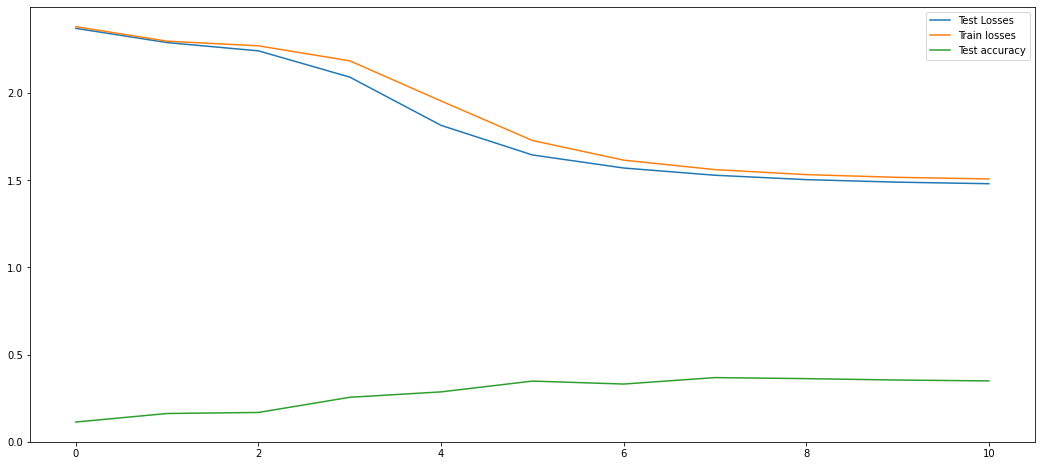

In [ ]:
# visualisation of our model's performance
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(range(num_epochs+1),test_losses,label="Test Losses")
plt.plot(range(num_epochs+1),train_losses, label="Train losses")
plt.plot(range(num_epochs+1),test_accuracies, label = "Test accuracy")
plt.legend()
plt.show()

Follow the creators: [Felix](https://github.com/MockaWolke) & [Louis](https://github.com/louiskhub) & [Yannik](https://github.com/Yannik101010)

